1.导入数据集

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.optimize import minimize 

In [6]:
data = sio.loadmat('C:\\Users\\Administrator\\Desktop\\ex5data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Fri Nov  4 22:27:26 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[-15.93675813],
        [-29.15297922],
        [ 36.18954863],
        [ 37.49218733],
        [-48.05882945],
        [ -8.94145794],
        [ 15.30779289],
        [-34.70626581],
        [  1.38915437],
        [-44.38375985],
        [  7.01350208],
        [ 22.76274892]]),
 'y': array([[ 2.13431051],
        [ 1.17325668],
        [34.35910918],
        [36.83795516],
        [ 2.80896507],
        [ 2.12107248],
        [14.71026831],
        [ 2.61418439],
        [ 3.74017167],
        [ 3.73169131],
        [ 7.62765885],
        [22.7524283 ]]),
 'Xtest': array([[-33.31800399],
        [-37.91216403],
        [-51.20693795],
        [ -6.13259585],
        [ 21.26118327],
        [-40.31952949],
        [-14.54153167],
        [ 32.55976024],
        [ 13.39343255],
        [ 44.20988595],
        [ -1.14267768],
        [-

In [9]:
x_train ,y_train = data['X'],data['y']
x_val ,y_val = data['Xval'],data['yval']
x_test ,y_test = data['Xtest'],data['ytest']

In [11]:
x_train = np.insert(x_train,0,values=1,axis=1)
x_val = np.insert(x_val,0,values=1,axis=1)
x_test = np.insert(x_test,0,values=1,axis=1)

2.数据可视化

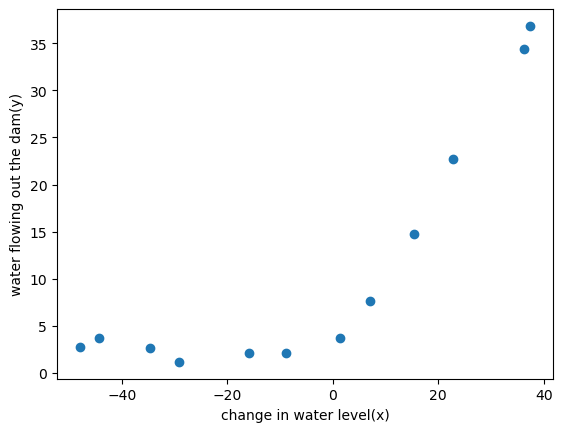

In [14]:
'''绘制散点图的函数 plot_data()。
它使用训练数据集的特征和标签来创建一个散点图，以可视化特征与标签之间的关系。'''


def plot_data():
    fig, ax = plt.subplots()  # 创建图形对象(fig)和一个坐标轴对象(ax)
    # 使用scatter函数绘制散点图，      X_train[:, 1]表示   使用训练数据集中第二列特征作为X轴坐标  水位的变化
    #                              y_train表示        使用训练数据集中的标签作为Y轴坐标      出水量
    # 按照每个样本的特征和标签的取值，在散点图显示它们之间的关系
    ax.scatter(x_train[:, 1], y_train)
    ax.set(xlabel='change in water level(x)',
           ylabel='water flowing out the dam(y)')


# 调用plot_data函数,看原始数据分布散点图
plot_data()
# 显示图形
plt.show()


3.损失函数

In [17]:
def costFunction(theta,X,y,lamda):
    cost = np.sum(np.power(X @ theta - y.flatten(),2))
    reg = lamda * np.sum(np.power(theta[1:],2))
    return (cost + reg) / (2*len(X))

#测试
lamda = 1
theta = np.ones(x_train.shape[1])
cost_init = costFunction(theta,x_train,y_train,lamda)
cost_init

303.9931922202643

4.梯度函数

In [22]:
def gradient(theta, X, y, lamda):
    grad = (X @ theta - y.flatten()) @ X
    reg = lamda * theta
    reg[0] = 0  # 不改变维度，直接赋值为0第一行不参与运算
    return (grad + reg) / (len(X))

# 测试梯度
result_gradient = gradient(theta, x_train, y_train, lamda)
print(result_gradient)  # [-15.30301567 598.25074417]

[-15.30301567 598.25074417]


5.定义训练函数

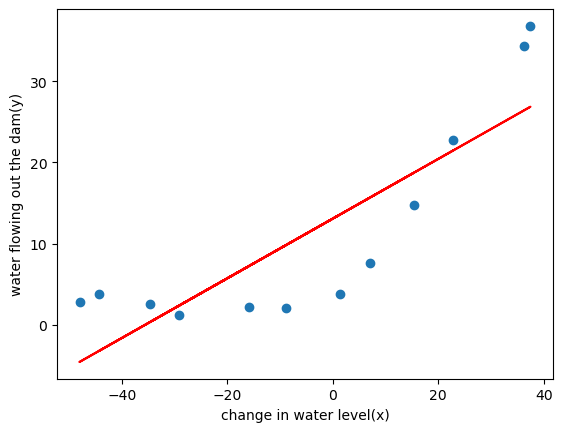

In [25]:
def train_model(X,y,lamda):
    theta = np.ones(X.shape[1])
    res = minimize(fun = costFunction,x0 = theta,args=(X,y,lamda),method = 'TNC', jac=gradient)
    return res.x

theta_final = train_model(x_train,y_train,lamda=0)
plot_data()
plt.plot(x_train[:,1],x_train @ theta_final,c='r')
plt.show()

6.绘制模型在训练集和验证集上的损失函数图像

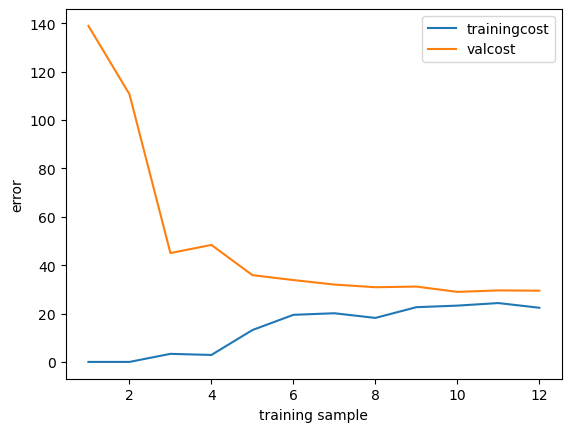

In [28]:
def plot_learning_curve(x_train,y_train,x_val,y_val,lamda):
    train_cost = []
    val_cost = []
    x = range(1,len(x_train)+1)
    for i in x:
        res = train_model(x_train[:i,:],y_train[:i,:],lamda)
        cost_train = costFunction(res,x_train[:i,:],y_train[:i,:],lamda)
        cost_val = costFunction(res,x_val,y_val,lamda)
        train_cost.append(cost_train) 
        val_cost.append(cost_val)
    plt.plot(x,train_cost,label='trainingcost')
    plt.plot(x,val_cost,label='valcost')
    plt.legend()
    plt.xlabel('training sample')
    plt.ylabel('error')
    plt.show()

plot_learning_curve(x_train,y_train,x_val,y_val,lamda)

结论：该模型属于高偏差，需增加特征数量

7.构造多项式特征生成函数

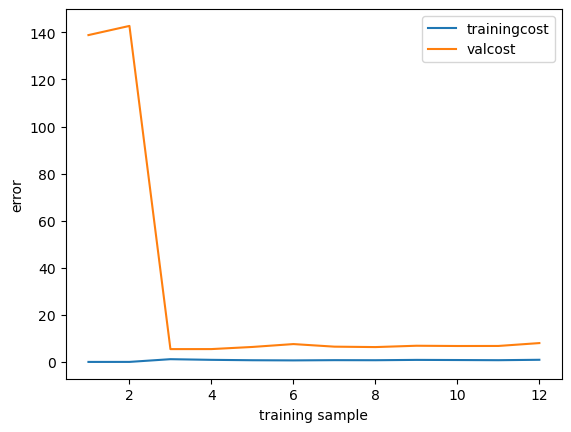

In [74]:
def poly_feature(x,power):
    for i in range (2,power+1):
        x = np.insert(x,x.shape[1],np.power(x[:,1],i),axis=1)
    return x

def get_mean_std(x):
    means = np.mean(x,axis=0)
    stds = np.std(x,axis=0)
    return means,stds

def feature_normalize(x):
    means,stds = get_mean_std(x[:,1:])
    x[:,1:] =(x[:,1:]- means) / stds
    return x

#测试
power = 4
#生成多特征训练、验证、测试集
x_train_poly = poly_feature(x_train,power)
x_val_poly = poly_feature(x_val,power)
x_test_poly = poly_feature(x_test,power)
#先获取均值和方差
train_means,train_stds = get_mean_std(x_train_poly)
val_means,val_stds = get_mean_std(x_val_poly)
test_means,test_stds = get_mean_std(x_test_poly)
lamda = 0.05
# 对训练集、验证集、测试集进行归一化处理
x_train_norm = feature_normalize(x_train_poly)
x_val_norm = feature_normalize(x_val_poly)
x_test_norm = feature_normalize(x_test_poly)

plot_learning_curve(x_train_norm,y_train,x_val_norm,y_val,lamda)

0 3 6.259174468252651


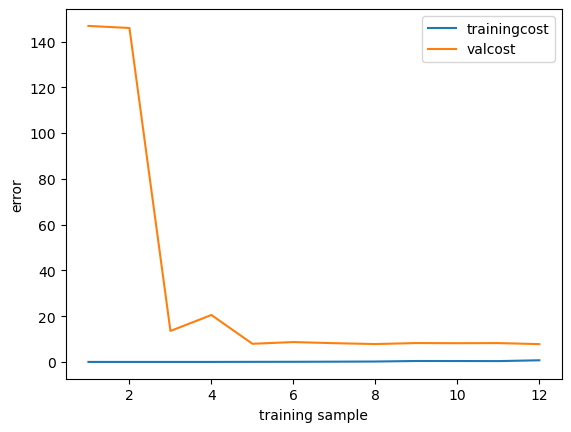

In [126]:
#寻找损失值最低的特征次数和lamda
lamdas = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
powers = [2,3,4,5,6]
min_cost = 10000000
min_lamda = 3
min_power = 2
for lamda in lamdas:
    for power in powers:
        #生成多特征训练、验证、测试集
       x_train_poly = poly_feature(x_train,power)
       x_val_poly = poly_feature(x_val,power)

       # 对训练集、验证集、测试集进行归一化处理
       x_train_norm = feature_normalize(x_train_poly)
       x_val_norm = feature_normalize(x_val_poly)
    
       res = train_model(x_train_poly,y_train,lamda)
       cost = costFunction(res,x_val_poly,y_val,lamda)
       if(cost<min_cost):
           min_cost = cost
           min_lamda = lamda
           min_power = power

print(min_lamda,min_power,min_cost)
x_train_poly = poly_feature(x_train,min_power)
x_test_poly = poly_feature(x_test,min_power)
x_train_norm = feature_normalize(x_train_poly)
x_test_norm = feature_normalize(x_test_poly)
plot_learning_curve(x_train_norm,y_train,x_test_norm,y_test,min_lamda)